<a href="https://colab.research.google.com/github/levente-1/notebooks/blob/main/MLN_2425_neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1WylQLZX3zEO2lmKY9m8-FbfliJcXFp8L)

# Machine Learning in Neuroscience

# Practical 7 - Neural Style Transfer

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.

You will be using the the epynomously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, you'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers).

As explained in the lecture, NST involves the optimisation of a generated image based on a style target and a content target. Throughout this notebook, we will refer to the generated image as G, the content image as C, and the style image as S.

<a name='1'></a>
## 1 - Cloning a GitHub repository and downloading packages

As part of this practical, we will use a [PyTorch implementation](https://github.com/gordicaleksa/pytorch-neural-style-transfer) of NST, written by Aleksa Gordic.

To begin, we will need to:

1.   Mount our drive to allow this notebook to access Google Drive
2.   Create a new folder
3.   Clone the repository into our newly created folder



In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! ls

drive  sample_data


In [8]:
cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive/pytorch_nst/pytorch-neural-style-transfer


In [ ]:
mkdir Practical7
cd Practical 7

In [ ]:
# Clone the GitHub repository containing all of the code we will be using
! git clone https://github.com/gordicaleksa/pytorch-neural-style-transfer

In [5]:
cd pytorch-neural-style-transfer

/content/drive/MyDrive/pytorch_nst/pytorch-neural-style-transfer


In [9]:
# Finally, import all packages required
import os
import shutil
import torch
from torch.optim import Adam, LBFGS
from torch.autograd import Variable
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

<a name='2'></a>
## 2 - Content Reconstruction

One goal you should aim for when performing NST is for the content in generated image G to match the content of image C. To do so, you'll need an understanding of the features captured by <b> shallow versus deep layers </b>.

We will begin by running a script that starts from random noise, and reconstructs image C by minimising the content loss only (MSE between features obtained from image G and features obtained from image C; see lecture). Before running our code, let's quickly take a look at our target image C:


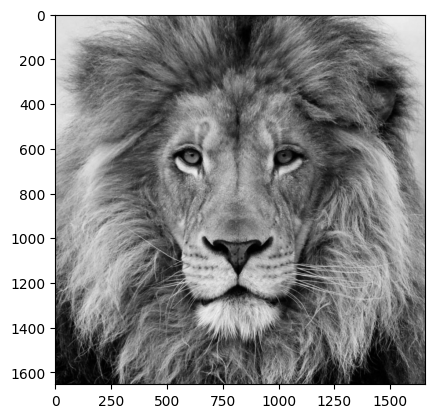

In [12]:
img_path = 'data/content-images/lion.jpg'
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.show()

Now let's run the code in the cell below, which calls on the <i> "reconstruct_image_from_representation.py" </i> script in your repository that you cloned from GitHub:

In [ ]:
!python reconstruct_image_from_representation.py

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100% 548M/548M [00:06<00:00, 84.3MB/s]
Number of feature maps: 128
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x48

<a name='4-1-1'></a>
#### 2.1 Feature maps from image C and reconstructed image

The outputs of the script above will be placed in:


- <i> data/output-images/c_reconstruction_lbfgs/lion </i>


Here, we will see two types of image files:


1.   Gradual reconstruction images from noise to content
2.   Feature maps in a given layer (in this case layer 2 of VGG-19)

To visualise the feature maps we captured from our image, run the code below:



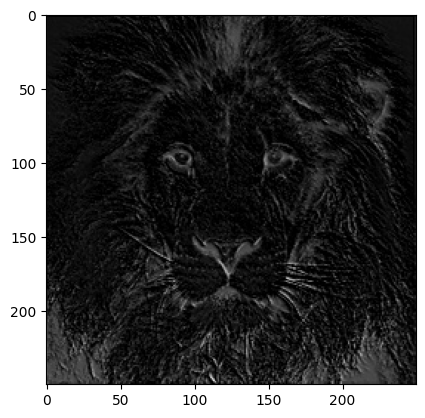

In [ ]:
filter_number = 69 # Can set this to anywhere between 0-127
img_path = 'data/output-images/c_reconstruction_lbfgs/lion/fm_vgg19_relu2_1_'+str(filter_number).zfill(4)+'.jpg'
img = mpimg.imread(img_path)
imgplot = plt.imshow(img, cmap='Accent')
plt.show()

To visualise the reconstructed image, we can use the cell below to create a GIF (going from pure noise to the final content image) or the cell afterwards to view individual reconstructions:

In [ ]:
# Running this cell may take 1-2 mins
from PIL import Image
outDir = 'data/output-images/c_reconstruction_lbfgs/lion'
images_lion = os.listdir(outDir)
for i in images_lion[:]:
  if 'vgg' in i or 'jpg' not in i:
    images_lion.remove(i)
images_final = []
for i in images_lion:
  im = Image.open(os.path.join(outDir, i))
  images_final.append(im)

images_final[0].save(os.path.join(outDir, 'Lion.gif'), save_all=True, append_images=images_final[1:], duration=40, loop=0)

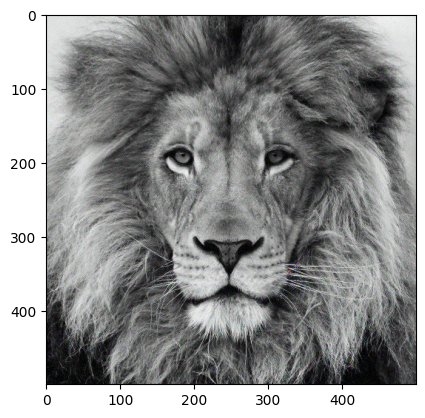

In [ ]:
# Note: you may need to change the number of the image file
img = mpimg.imread('data/output-images/c_reconstruction_lbfgs/lion/0358.jpg')
imgplot = plt.imshow(img, cmap='Accent')
plt.show()

<a name='4-1-1'></a>
#### 2.2 Feature maps from different layers

The script, as written by default, uses layer 2 from VGG to obtain feature maps. As we saw above, this results in features that capture fine details.

To see what feature maps are obtained using deeper layers, we need to modify our script. To do this, complete the following steps:

1.   Double-click on <i> "models/definitions/vgg_nets.py" </i> to open an editor
2.   On line 176, change <i> self.content_feature_maps_index </i> from 1 to 4. This will allow us to extract features from layer 5 instead of layer 2
3.   To make sure a new directory is created when rerunning <i> "reconstruct_image_from_representation.py" </i>, double click on this script and change line 46 by altering 'dump_path' with an added suffix of your choice

Once all these steps are completed, we are now ready to reconstruct content from noise again by running the cell below:




In [ ]:
!python reconstruct_image_from_representation.py

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100% 548M/548M [00:04<00:00, 140MB/s]
Number of feature maps: 512
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480

Let's visualise the feature maps obtained, this time from Layer 5 of VGG. Do you see any differences compared to what we saw from earlier layers?

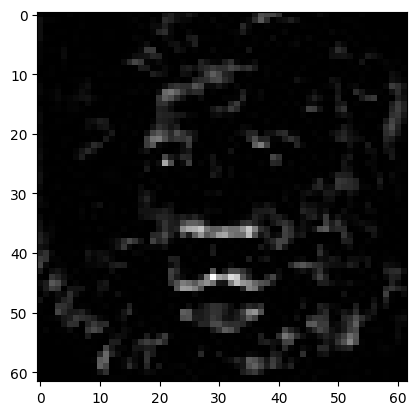

In [ ]:
filter_number = 11 # Can set this to anywhere between 0-511
img_path = 'data/output-images/c_reconstruction_lbfgs2/lion/fm_vgg19_conv4_2_'+str(filter_number).zfill(4)+'.jpg'
img = mpimg.imread(img_path)
imgplot = plt.imshow(img, cmap='Accent')
plt.show()

Now let's visualise the reconstructed content image. How does this differ from the previous reconstructed image?

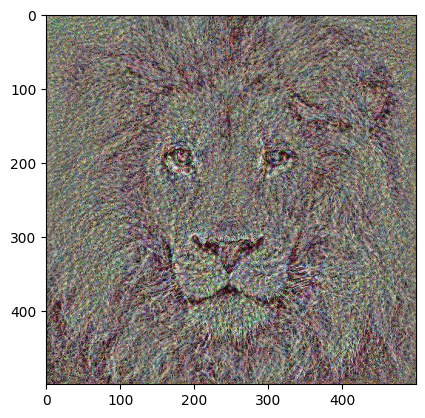

In [ ]:
# You may need to change the number of the image file
img = mpimg.imread('data/output-images/c_reconstruction_lbfgs2/lion/0358.jpg')
imgplot = plt.imshow(img, cmap='Accent')
plt.show()

<a name='2'></a>
## 3 - Style Reconstruction

The second goal you should aim for when performing NST is for the style in the generated image G to match the style of image S. To do so, you'll need an understanding of <b> Gram matrices. </b>

To viualise Gram matrices and see how they aid in conveying style, we will use the same script as above with some minor modifications. Once again, we will start from random noise, however this time we will gradually construct an image that matches the style of image S by minimisng the style loss only (MSE between Gram matrices from 5 different layers, obtained from both image G and image S; see lecture). Before running our code, let's quickly take a look at image S:


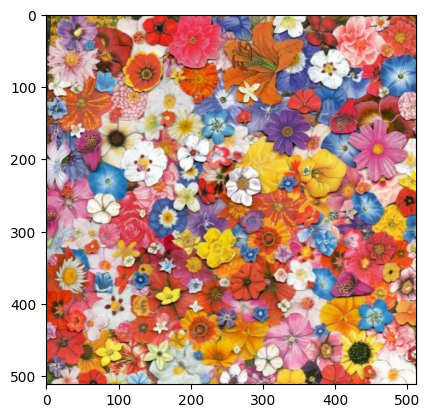

In [11]:
img_path = 'data/style-images/ben_giles.jpg'
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.show()

Now, let's make the following edits to our code:

1.   Open <i> "reconstruct_image_from_representation.py" </i> to edit the file
2.   Revert line 46 back to the original, such that no extra suffix is added to "dump_path"
3.   Change the <i> should_reconstruct_content </i> argument in line 155 to False: this will ensure the style reconstruction is carried out instead of content reconstruction


After completing these steps you are now ready to run the cell below:

In [ ]:
!python reconstruct_image_from_representation.py

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Number of Gram matrices: 5
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Iteration: 0, current style loss=268914784.0
Iteration: 1, current style loss=268914688.0
Iteration: 2, current style loss=268914080.0
Iteration: 3, current style loss=268913184.0
Iteration: 4, current style loss=268905920.0
Iteration: 5, current style loss=268851776.0
Iterat

<a name='4-1-1'></a>
#### 3.1 Gram matrices from different layers

The outputs of the script above will be placed in:


- <i> data/output-images/s_reconstruction_lbfgs/ben_giles </i> (given that Ben Giles style image was used).


Here, we will see two types of image files:


1.   Gradual construction of style images
2.   Gram matrices from layers 1-5

To visualise the Gram matrices we captured from image S, run the code below:


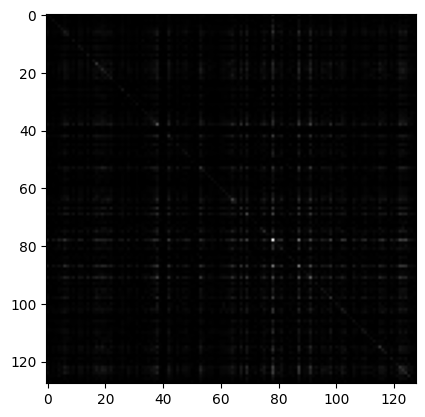

In [ ]:
filter_number = 1 # Can set this to anywhere between 0-4
layer_names = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'conv4_2']
img_path = 'data/output-images/s_reconstruction_lbfgs/ben_giles/gram_vgg19_' + layer_names[filter_number] + '_' + str(filter_number).zfill(4) + '.jpg'
img = mpimg.imread(img_path)
imgplot = plt.imshow(img, cmap='Accent')
plt.show()



To visualise our style reconstruction, we can use the cell below to create a GIF (going from pure noise to the final style image) or the cell afterwards to view individual reconstructions.

In [ ]:
from PIL import Image
outDir = 'data/output-images/s_reconstruction_lbfgs/ben_giles'
images_ben_giles = os.listdir(outDir)
for i in images_ben_giles[:]:
  if 'gram' in i or 'jpg' not in i:
    images_ben_giles.remove(i)
images_final = []
for i in images_ben_giles:
  im = Image.open(os.path.join(outDir, i))
  images_final.append(im)

images_final[0].save(os.path.join(outDir, 'Ben_Giles.gif'), save_all=True, append_images=images_final[1:], duration=40, loop=0)

KeyboardInterrupt: 

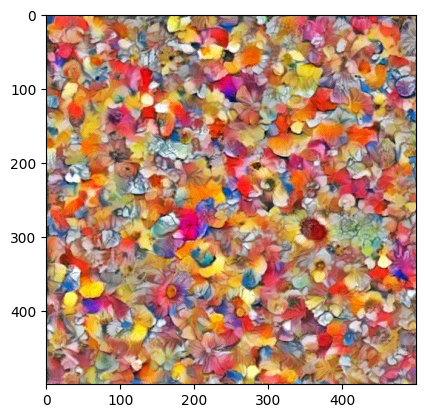

In [ ]:
# Note: you may need to change the number of the image file
img = mpimg.imread('data/output-images/s_reconstruction_lbfgs/ben_giles/0373.jpg')
imgplot = plt.imshow(img, cmap='Accent')
plt.show()

<a name='2'></a>
## 4 - Neural Style Transfer

Finally, we are ready to run <strong>Neural Style Transfer</strong>. For this, we start with image C instead of a random noise image, and gradually inject the style of image S by minimising the style loss. Importantly, we by keeping track of the content loss during this time and make that it stays low, ensuring that the new style we inject does not make our original image unrecognisable.

To see this process in action, run the code in the cell below, which calls on the <i> "neural_style_transfer.py" </i> script in your repository

In [ ]:
!python neural_style_transfer.py

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using vgg19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=3959433199616.0000, content_loss=      0.0000, style loss=3959430240000.0000, tv loss=2982651.0000
L-BFGS | iteration: 001, total loss=3959431102464.0000, content_loss=      0.0002, style loss=3959428320000.0000, tv loss=2982651.7500
L-BFGS | iteration: 002, total loss=3959430053888.0000, content_loss= 

<a name='4-1-1'></a>
#### 4.1 Visualising the outputs

The outputs of the script above will be placed in:

- <i> data/output-images/combined_lion_ben_giles </i>


The folder will contain an image from each training epoch, gradually transforming the generated image to be a combination of image C and image S. Use the cell below to create a GIF that captures this transformation, or the cell afterwards to view the final image:

In [ ]:
from PIL import Image
outDir = 'data/output-images/combined_lion_ben_giles'
images_ben_giles = os.listdir(outDir)
for i in images_ben_giles[:]:
  if 'vgg' in i or 'jpg' not in i:
    images_ben_giles.remove(i)
images_final = []
for i in images_ben_giles:
  im = Image.open(os.path.join(outDir, i))
  images_final.append(im)

images_final[0].save(os.path.join(outDir, 'Lion_Ben_Giles.gif'), save_all=True, append_images=images_final[1:], duration=40, loop=0)

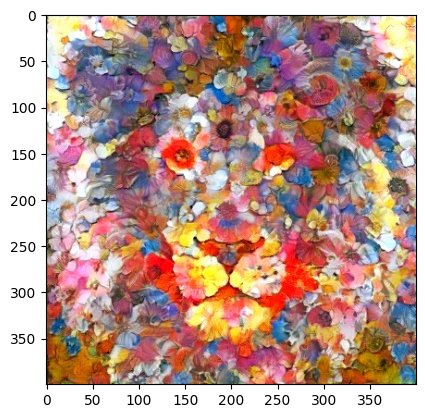

In [ ]:
# Note: you may need to change the number of the image file
img = mpimg.imread('data/output-images/combined_lion_ben_giles/1015.jpg')
imgplot = plt.imshow(img, cmap='Accent')
plt.show()

<a name='4-1-1'></a>
#### 4.2 Experimenting

Now it's your turn to experiment with the code. Try and see if changing the layers from VGG (from vgg.py) or  altering the weights of the style and content loss (in neural_style_transfer.py) has effects on the constructed imgae. If so, what happens when changing these arguments?

Finally, try this out with different content and style images from the ones provided, or upload your own jpg images!